# **AstrID:**  *predictions*

### Importing Necessary Libraries and Modules

In this section, we import the necessary libraries and modules required for validating our model. These include:

- **TensorFlow and Keras**: For loading and using the trained neural network.
- **NumPy**: For numerical operations and handling arrays.
- **Matplotlib**: For plotting and visualizing data.
- **Astropy**: For handling FITS files and WCS data.
- **Custom Functions**: 
    - [`dataGathering`](dataGathering.py): to handle data extraction.
    - [`imageProcessing`](imageProcessing.py): for image modification to fit model requirements.

The comments in the code provide additional details about each import.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from tensorflow import keras
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K

import os
import datetime
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS

# Import custom functions to import the dataset
from dataGathering import importDataset

# Import custom functions to extract pixel coordinates from the star catalog to facilitate the pixel mask overlay
from dataGathering import getPixelCoordsFromStar

# Import custom function to preprocess Image and Pixel Mask arrays
from imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage
from imageProcessing import plot_image_mask_prediction_subplot, save_image_mask_prediction_subplot, extract_star_predictions, plot_image_mask_prediction_overlay, save_image_mask_prediction_overlay

2024-11-24 11:33:25.362669: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 11:33:26.004792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-11-24 11:33:27.286109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 11:33:27.322168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 11:33:27.322255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    
    # Clear GPU memory
    K.clear_session()
    tf.config.experimental.reset_memory_stats('GPU:0')

GPU is available


2024-11-24 11:33:27.335169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 11:33:27.335269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 11:33:27.335317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 11:33:27.482869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-24 11:33:27.482959: I tensorflow/compile

### Loading the Dataset

We load the dataset using the `importDataset` function from the `dataGathering` module. This function extracts the images, masks, star data, WCS data, and FITS file names from the specified dataset path.

In [4]:
# Create images and masks arrays lists
images = []
masks = []

# Create a list of all the wcs data in the dataset folder
wcs_data = []

# Create df to store the star data inside each fits file
stars_in_image = []

# Createa a list of all the fits files in the dataset
fits_files = []

# Define the path to the dataset
dataset_path = 'data/fits/'

# Define the name of the dataset ('data' for training)
dataset_name = 'validate'

# Import the dataset
images, masks, stars_in_image, wcs_data, fits_files = importDataset(dataset_path=dataset_path, dataset_name=dataset_name)

Number of stars in catalog query:  508
validate3.fits added to dataset
Number of stars in catalog query:  666
validate17.fits added to dataset
Number of stars in catalog query:  3356
validate22.fits added to dataset
Number of stars in catalog query:  478
validate41.fits added to dataset
Number of stars in catalog query:  621
validate12.fits added to dataset
Number of stars in catalog query:  1224
validate32.fits added to dataset
Number of stars in catalog query:  1215
validate47.fits added to dataset
Number of stars in catalog query:  629
validate33.fits added to dataset
Number of stars in catalog query:  729
validate27.fits added to dataset
Number of stars in catalog query:  562
validate37.fits added to dataset
Number of stars in catalog query:  602
validate40.fits added to dataset
Number of stars in catalog query:  937
validate24.fits added to dataset
Number of stars in catalog query:  3967
validate16.fits added to dataset
Number of stars in catalog query:  928
validate18.fits added 

### Preparing Images and Masks for the Model

To ensure our images and masks are in the correct format for validation, we need to perform some transformations. Our model expects the images to have three channels, similar to standard RGB images, and the masks to have a single channel. Here’s how we achieve this:

**Convert Images to 3-Channel Format:** Our images are currently in the shape `(512, 512)`, but the model requires them to be in the shape `(512, 512, 3)`. To convert the single-channel images into 3-channel images, we stack the images along the last axis three times. This transformation is necessary because the model typically expects 3-channel input images.

**Convert Masks to Single-Channel Format:** For the masks, the model expects them to be in the shape `(512, 512, 1)`. We expand the masks along the last axis to add a new dimension, ensuring they have the correct shape.

**Convert to NumPy Arrays:** Both the images and masks need to be converted to NumPy arrays, as this is the desired format for the validation model. This conversion ensures that the data is in the correct format for validation.

Below, we perform these conversions to ensure the data is in the correct format for validation.

In [5]:
test_images = stackImages(images)
test_masks = stackMasks(masks)

### Normalizing the Images

To standardize the pixel values in our images, we need to normalize them to a common range. We will use min-max normalization to scale the pixel values to a range between 0.0 and 1.0.

In [6]:
# test_images = normalizeImages(test_images)

### Choose the Correct Model

We display models in the saved models directory. The most recent model is chosen to load, if you train and save a new model ensure it is listed as the `model_choice`.

In [7]:
# Display all the models in the models folder
saved_models_path = 'models/saved_models/'
model_files = os.listdir(saved_models_path)
model_files = [file for file in model_files if file.endswith('.keras')]
model_files = sorted(model_files)
model_files


['2024_11_18-0145_200_unet_model_chris.keras',
 '2024_11_18-0826_200_unet_model_chris.keras',
 '2024_11_19-0932_200_unet_model_chris.keras',
 '2024_11_19-1653_200_unet_model_chris.keras',
 '2024_11_20-1851_200_unet_model_chris.keras',
 '2024_11_21-2159_200_unet_model_chris.keras',
 '2024_11_23-1211_200_unet_model_chris.keras',
 '2024_11_24-1116_200_unet_model_chris.keras']

In [8]:
# Pick the most recent model
model_choice = model_files[-1]

In [9]:
#List your model choice to load for verification
model_choice

'2024_11_24-1116_200_unet_model_chris.keras'

### Loading the Trained Model

We load the trained U-Net model from the saved models directory. The model is used to make predictions on the test dataset.

In [10]:
# Load the saved model
# model_choice = '2024_11_08-1527_200_unet_model.keras'
model = load_model(saved_models_path + model_choice)

### Evaluating the Model

We evaluate the model's performance on the test dataset. We calculate the loss and accuracy metrics to assess the model's effectiveness.

In [11]:
# Reduce batch size for evaluation
batch_size = 4

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_images, test_masks, batch_size=batch_size, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2024-11-24 11:33:39.624217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


13/13 [==============================] - 3s 129ms/step - loss: 0.0421 - accuracy: 0.9963
Test Loss: 0.042074814438819885
Test Accuracy: 0.9963021874427795


### Making Predictions

We use the trained model to make predictions on the test dataset. The predictions are compared with the ground truth masks to evaluate the model's performance.

In [12]:
predictions = model.predict(test_images, batch_size=batch_size, verbose=1)

13/13 [==============================] - 1s 69ms/step


### Visualizing Results

We visualize the results by plotting the original images, ground truth masks, and predicted masks. This helps us understand how well the model is performing.

1/1 [==============================] - 0s 21ms/step


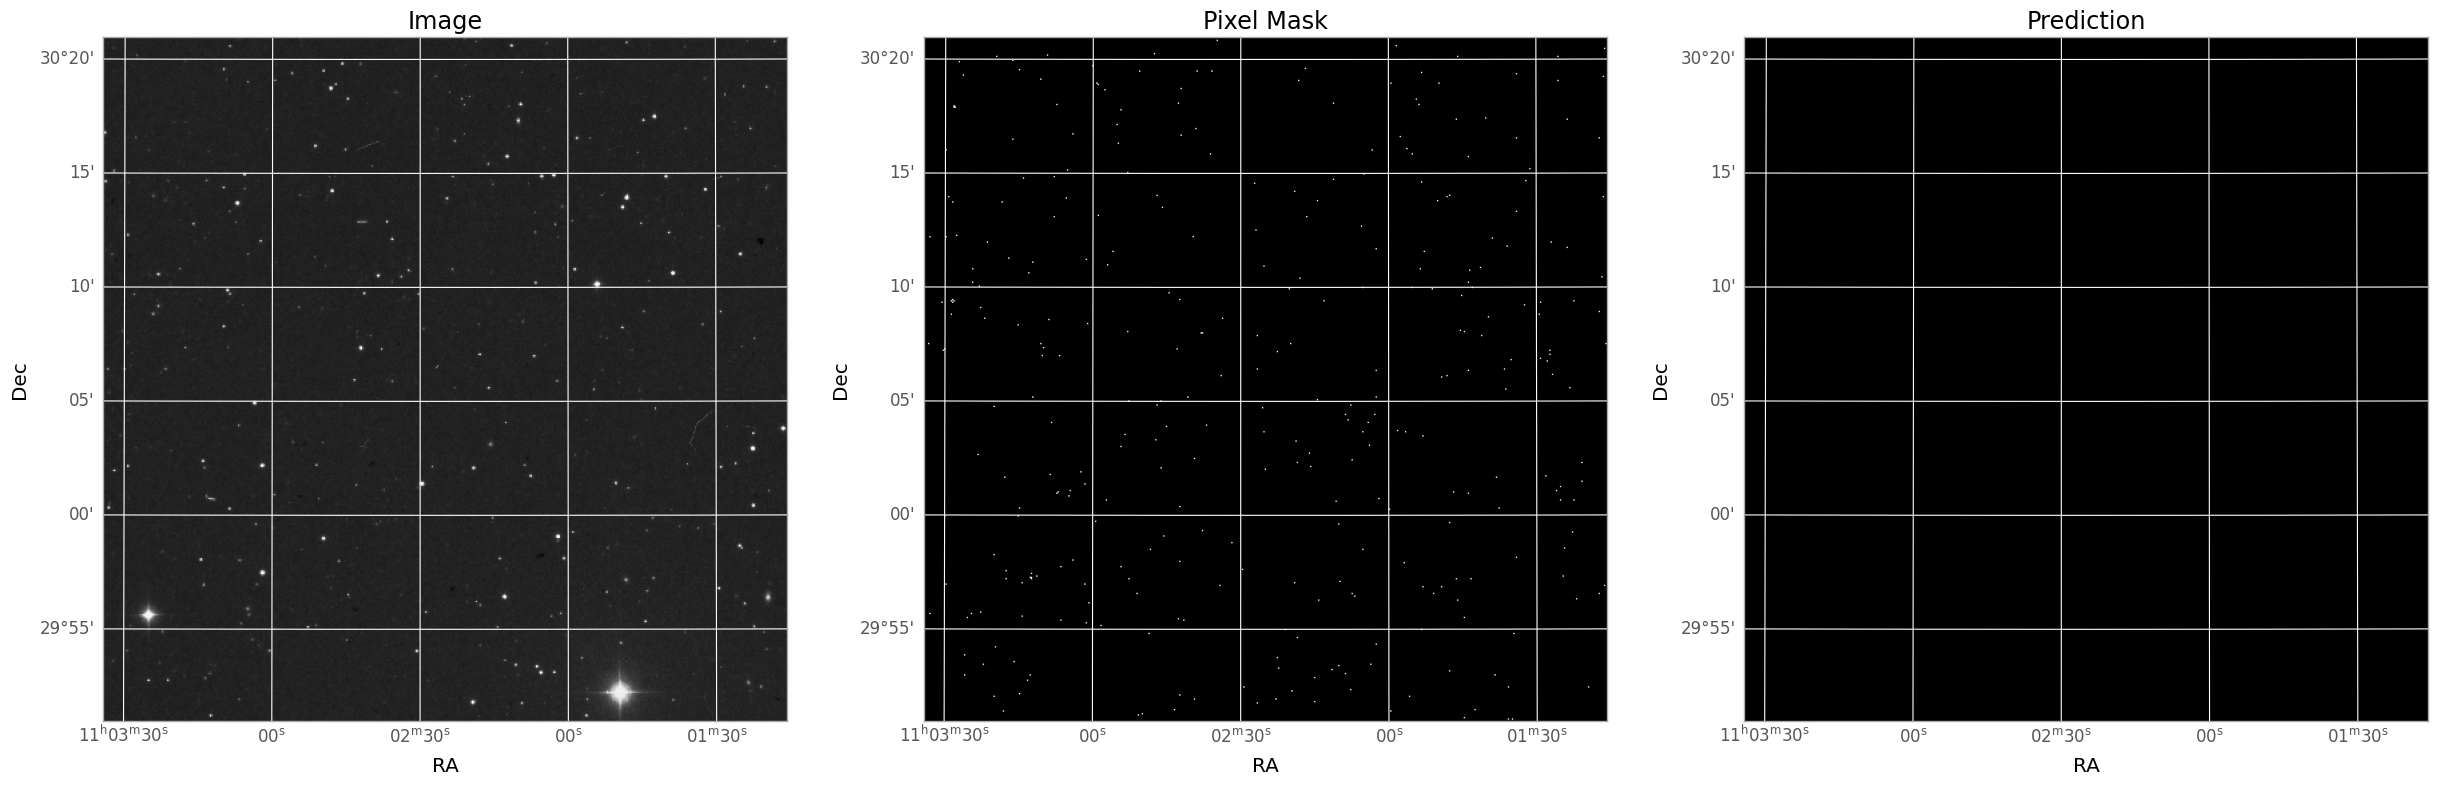

1/1 [==============================] - 0s 21ms/step
0
Drawing


/home/chris/github/AstrID/imageProcessing.py:150: RuntimeWarning: invalid value encountered in divide
  prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())


Drawing


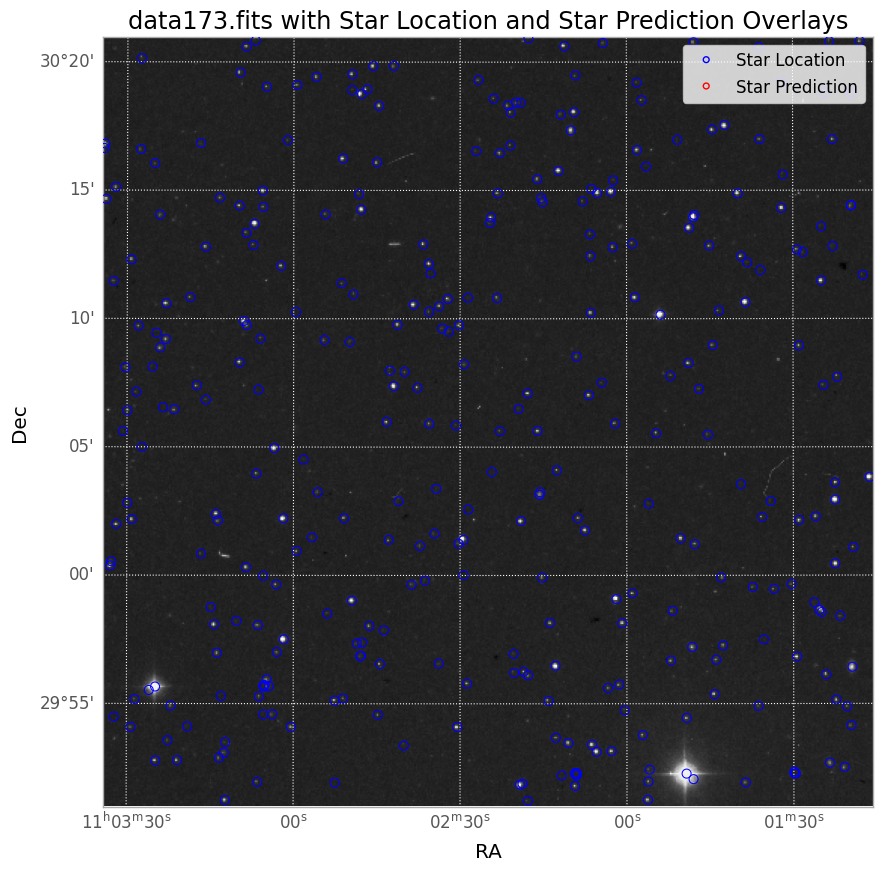

1/1 [==============================] - 0s 19ms/step


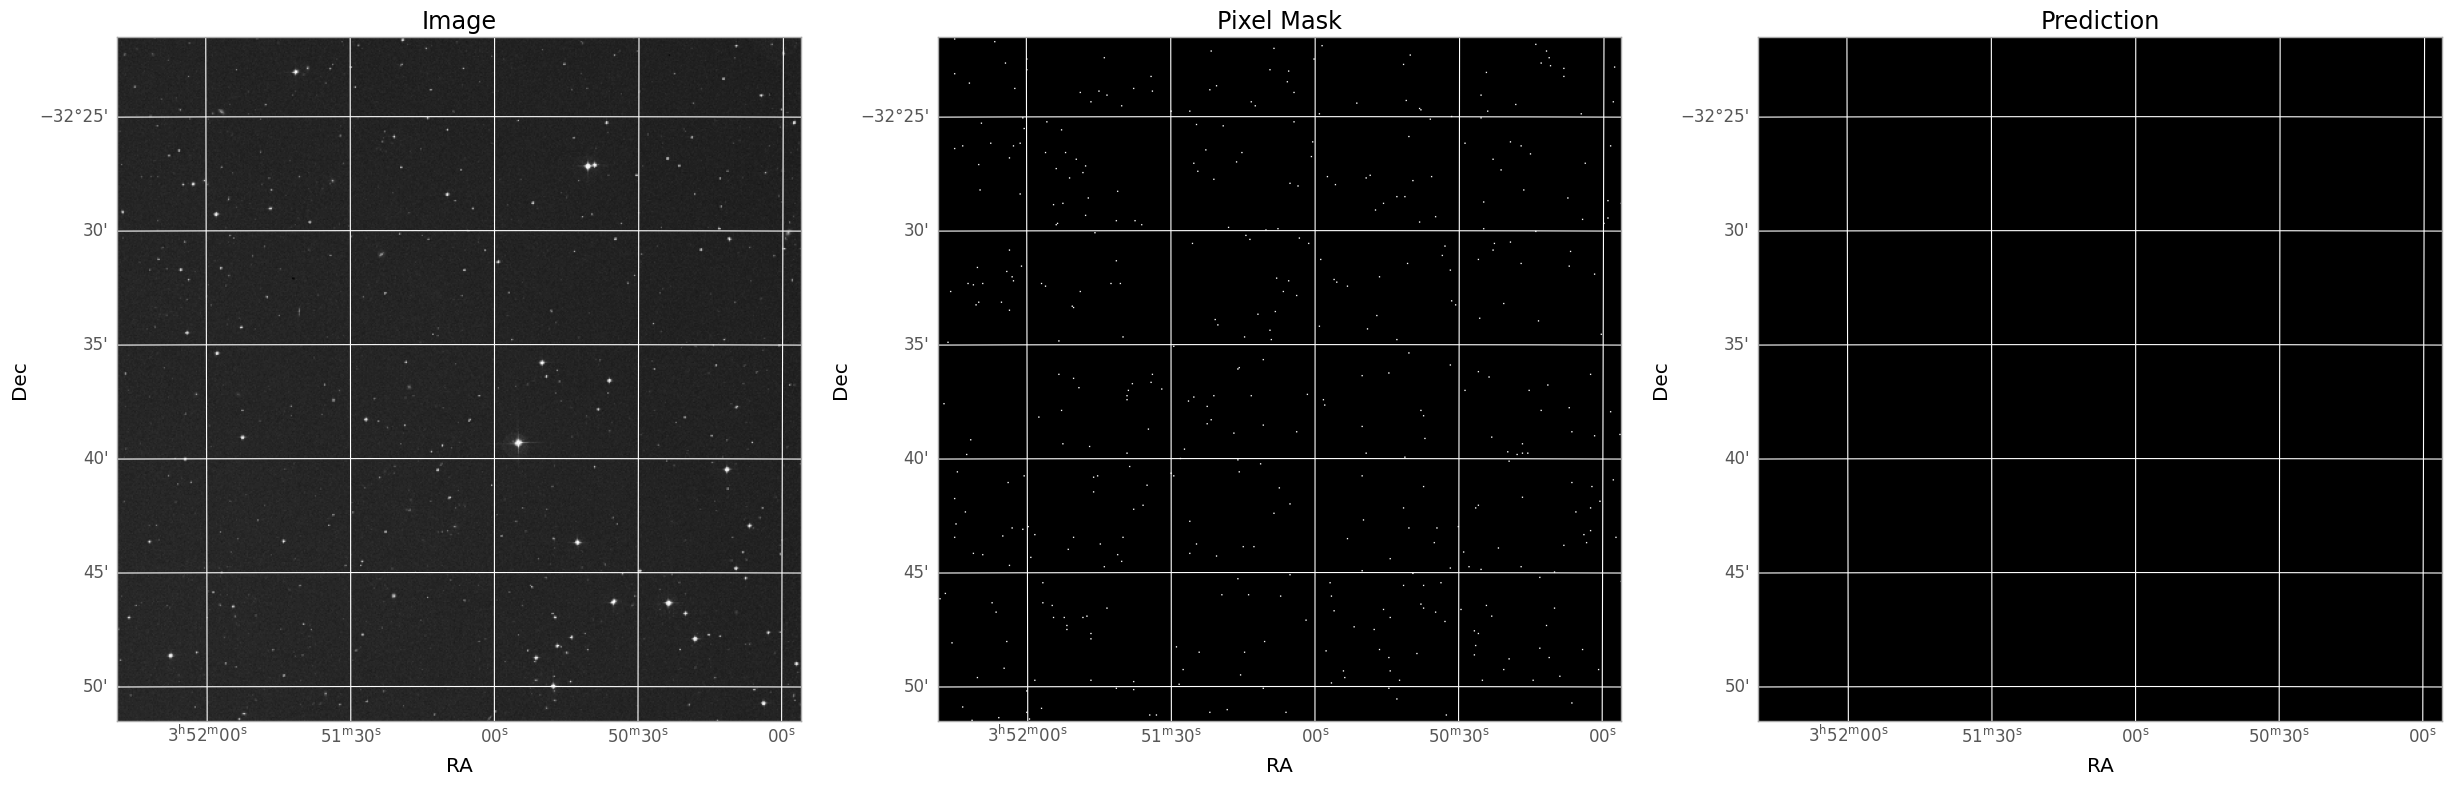

1/1 [==============================] - 0s 28ms/step
0
Drawing


/home/chris/github/AstrID/imageProcessing.py:150: RuntimeWarning: invalid value encountered in divide
  prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())


Drawing


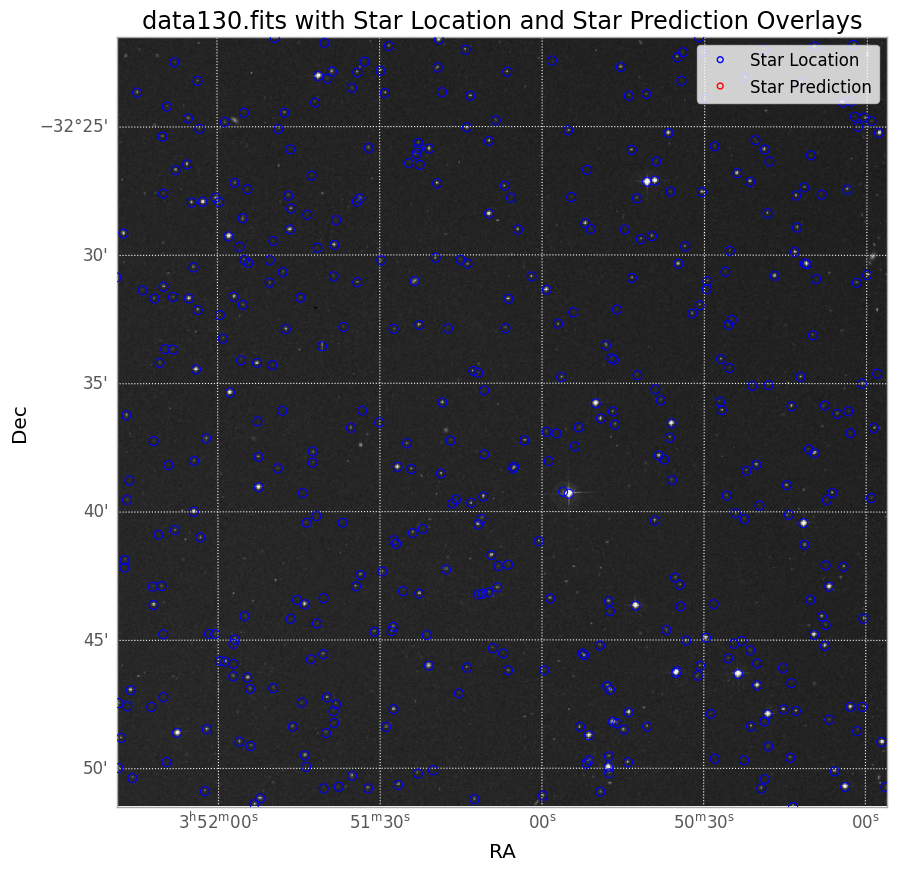

1/1 [==============================] - 0s 20ms/step


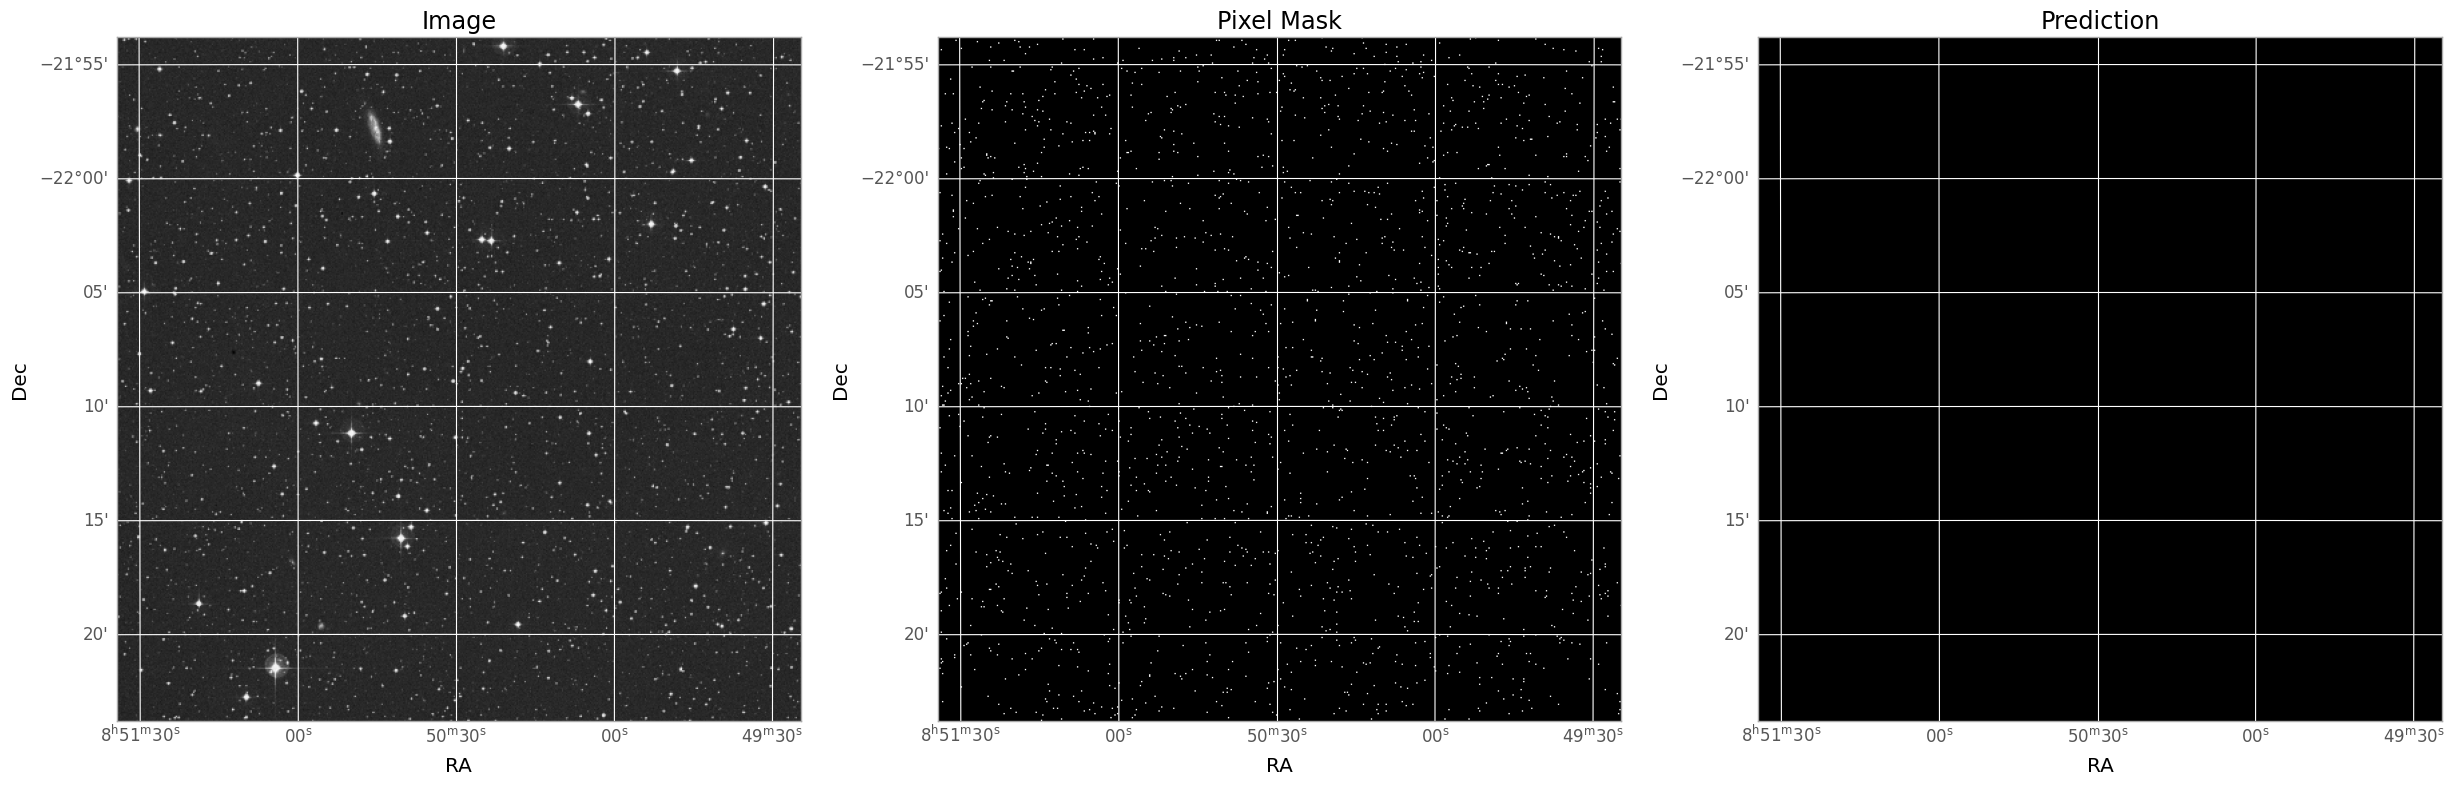

1/1 [==============================] - 0s 23ms/step
0
Drawing


/home/chris/github/AstrID/imageProcessing.py:150: RuntimeWarning: invalid value encountered in divide
  prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())


Drawing


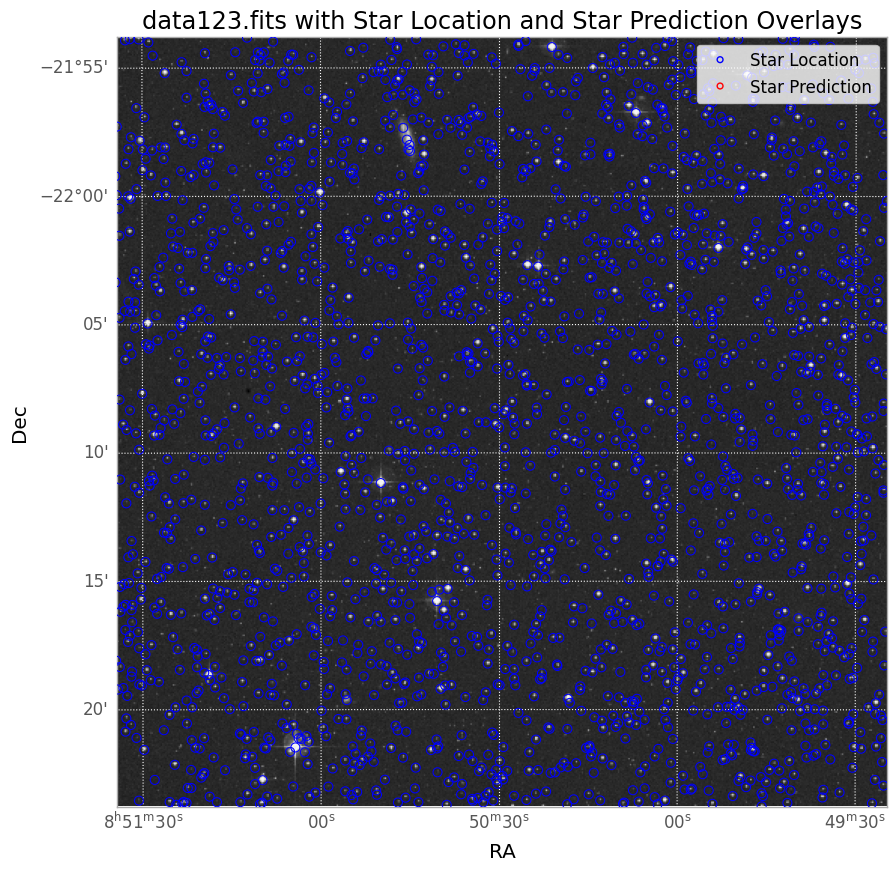

1/1 [==============================] - 0s 22ms/step


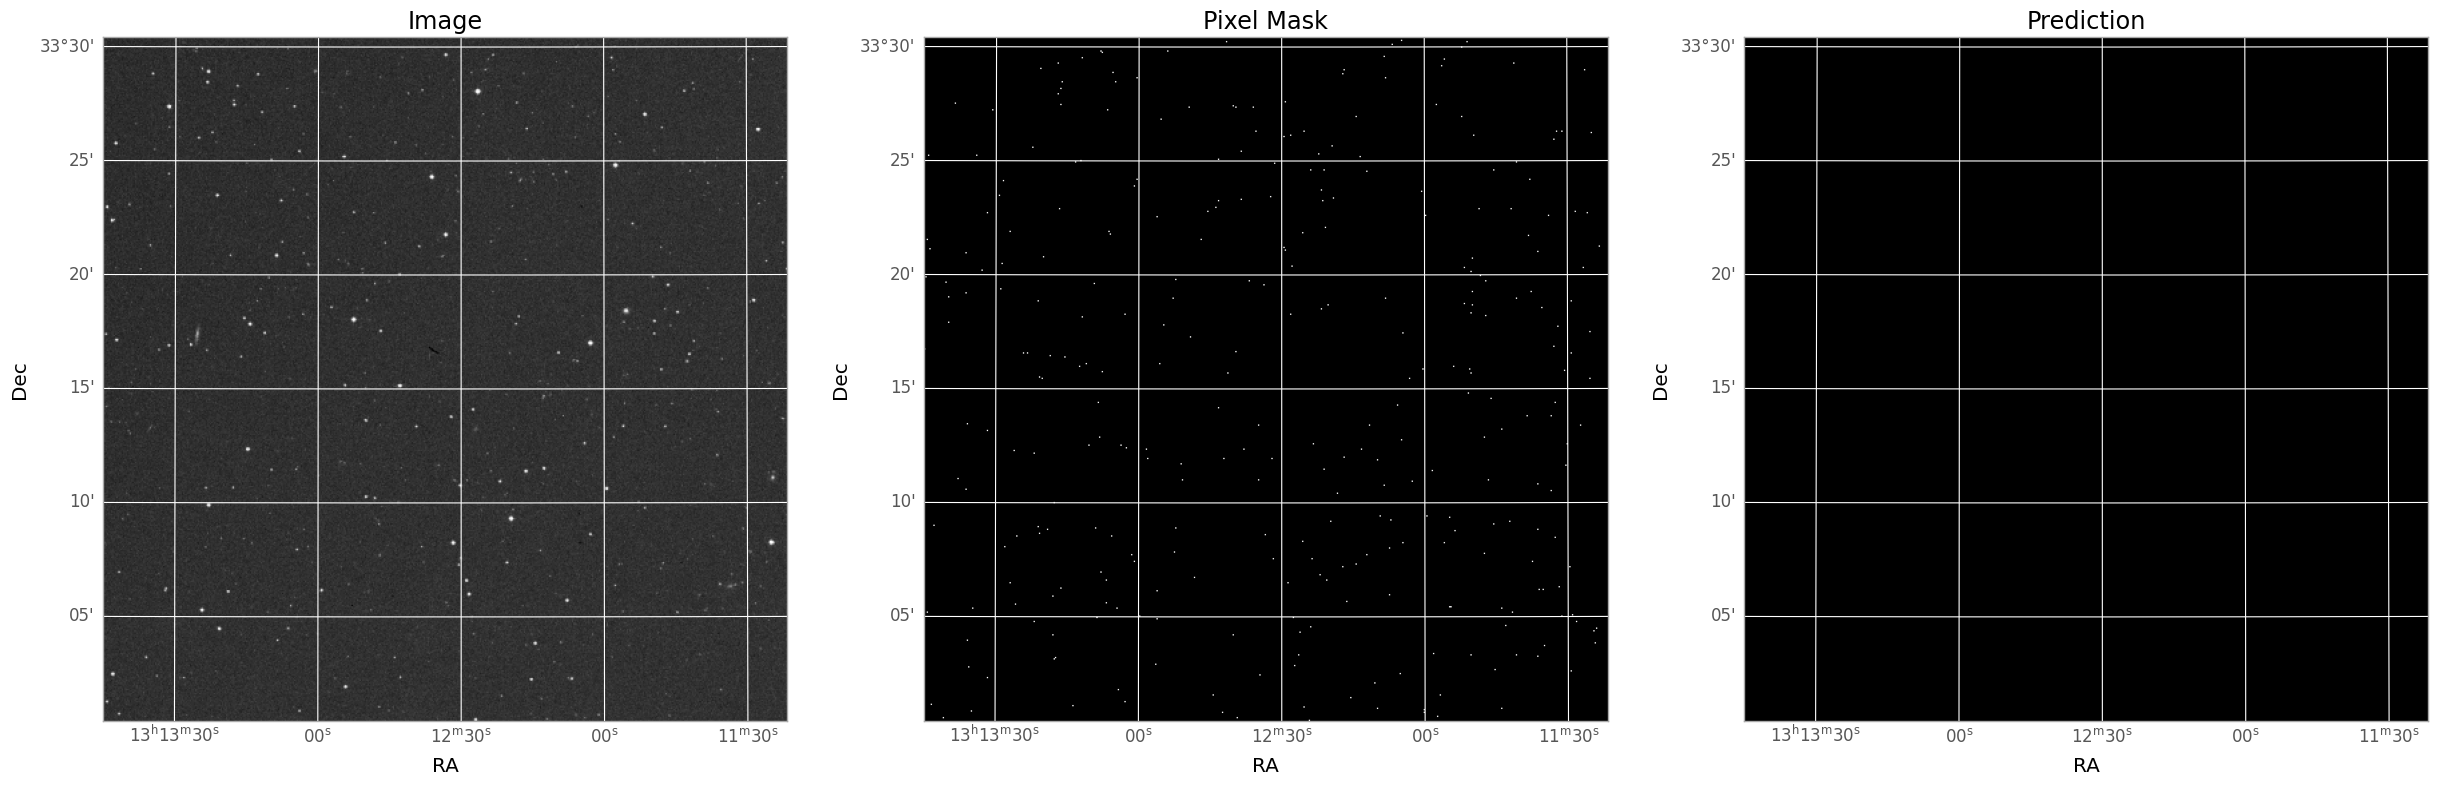

1/1 [==============================] - 0s 35ms/step
0
Drawing


/home/chris/github/AstrID/imageProcessing.py:150: RuntimeWarning: invalid value encountered in divide
  prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())


Drawing


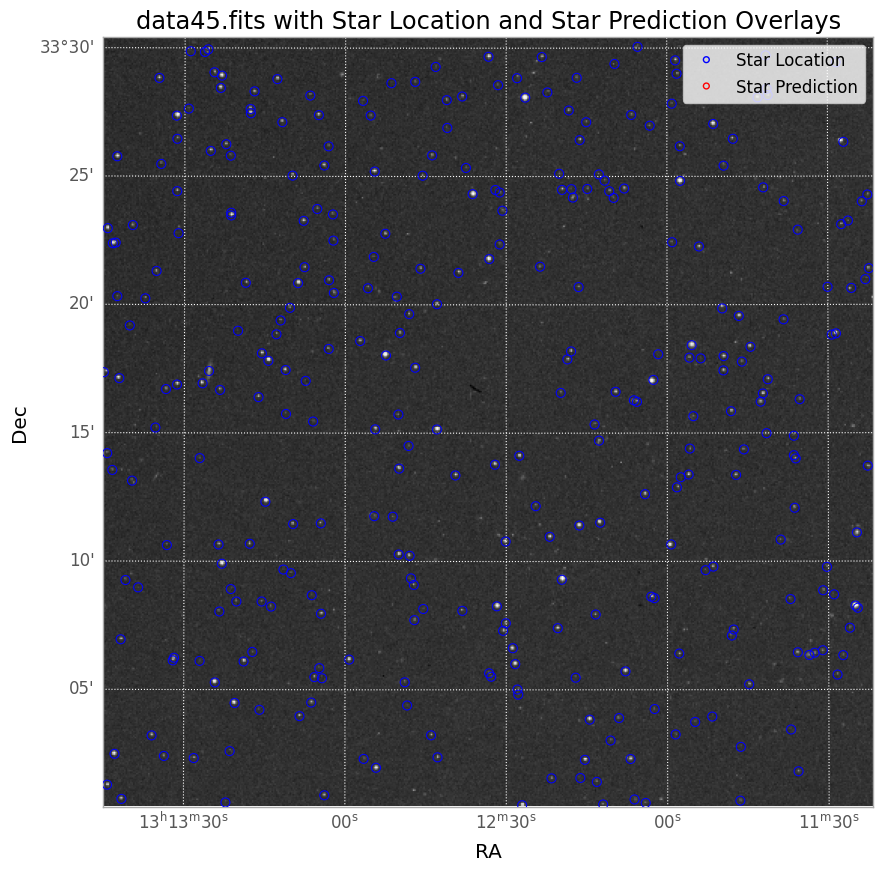

In [22]:
# Plot the results from the model
for i in range(4):
    plot_image_mask_prediction_subplot(images, test_masks, test_images, model, wcs_data, selection = i)
    plot_image_mask_prediction_overlay(images, test_masks, test_images, model, stars_in_image, wcs_data, fits_files, selection=i, threshold=0.05)

### Saving Results

We save the results, including the original images, ground truth masks, and predicted masks, to the results directory. This allows us to review and analyze the model's performance later.

In [ ]:
# # Iterate over the test set and save the image with overlayed mask and prediction to a file
# for i in range(len(test_images)):
#     save_image_mask_prediction_subplot(images, test_masks, test_images, model, wcs_data, fits_files, selection = i):    
#     save_image_mask_prediction_overlay(images, test_masks, test_images, model, stars_in_image, wcs_data, fits_files, selection=i, threshold=0.05)